Для себя:
можно было бы спарсить адрес каждой квартиры, задать удаленность квартиры от центра, что очень важно. (мб это попробовать сделать через отправку запроса через яндекс метро (к этому времени плюсовать еще время до метро пешком))

Тема проекта:
Анализ рынка аренды квартир в Москве на основе данных с сайта Циан.

Актуальность проекта:
Многие студенты как раз к третьему, четвертому курсу начинают задумываться о съеме квартиры. В москве этот рынок огромен, сложно просматривать все объявления, выцепляя наилучшие варианты. В этом проекте мы хотим проанализировать рынок аренды квартир в москве на основе данных Циан. Также мы хотим обучить модель, которая будет определять квартиры, которые имеют цену ниже рыночной. Тогда можно было бы определить механизм выделения наиболее интересных вариантов квартир.


Парсинг данных:

In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import random
import time

def get_link_announcement(page, count_links):
    
    response = requests.get(f'https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p={page}&region=1&room1=1&room2=1&room9=1&type=4')
    count_links_new = 0

    if response.status_code == 200:
        tree_link = BeautifulSoup(response.text, 'html.parser')
        
        # Находим все элементы, где находится ссылка на объявление
        announcement_links = tree_link.find_all('a', class_="_93444fe79c--media--9P6wN")
        
        # Ссобираем ссылки в отдельный список
        link_list = [link.get('href') for link in announcement_links]
        count_links_new = len(link_list)
        count_links +=  count_links_new
        
        # Записываем все ссылки в файл
        with open('C:\\артем общее2\\учеба\\уник\\python\\питон2\\Проект\\ИТОГ\\Data_links.txt', 'a', encoding='utf-8') as file:
            for link in  link_list:
                file.write(link + '\n')
                
    elif response.status_code == 429:
        try:
            retry_after = int(response.headers["Retry-After"])
            print(f'Слишком много запросов. Повторная попытка через {retry_after} секунд.')
            time.sleep(retry_after)
        except Exception as e:
            print(f'Ошибка получения времени ожидания:', e)
            time.sleep(10)  # Ожидание по умолчанию
        page -= 1
    
    return count_links,  count_links_new, page 



In [17]:
#Спарим данные ссылки на все объявления, которые можем спарсить без использования Selenium (по методу проб и ошибок выяснилось, что у Циан всего 54 страицы можно перебрать по ссылки, а дальше на странице 54 нужно добавлять данные через кнопку 'Показать еще')

count_links = 0
page = 0
percing = True

total_pages = 54
pbar = tqdm(total=total_pages, desc='Pages received')
while page <= total_pages and percing:
    page += 1
    count_links, count_links_new, page = get_link_announcement(page, count_links)
    time.sleep(2 + random.uniform(0, 2))
    if count_links % 1000 == 0 and count_links > 0:
        time.sleep(180)
    pbar.update(1)
del pbar
print(f'Всего было добавлено {count_links} ссылок и {page} страниц')

Pages received: 100%|██████████| 54/54 [04:50<00:00,  5.29s/it]

Ошибка получения времени ожидания: 'retry-after'


Pages received: 55it [05:04,  8.04s/it]                        

Ошибка получения времени ожидания: 'retry-after'


Pages received: 57it [05:26,  5.73s/it]

Всего было добавлено 1536 ссылок и 55 страниц


In [144]:
links_1 = []
with open('C:\\артем общее2\\учеба\\уник\\python\\питон2\\Проект\\ИТОГ\\Data_links.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        links_1.append(line)
print(len(set(links_1)))


1449


Теперь спарсим данные по каждой ссылке

In [146]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import random
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from fake_useragent import UserAgent
import pandas as pd
import json
from tabulate import tabulate

# Задам основные параметры, которые буду выгружать. Далее будет проверяться, есть ли эти данные на каждому странице. Если их не будет, то будет добавляться nan
info = {
    'Link':[],'Цена':[],'Пешком до метро':[],'Общая площадь':[], 'Жилая площадь':[],'Площадь кухни':[], 'Высота потолков':[], 'Санузел':[], 'Балкон/лоджия':[], 
    'Ремонт':[], 'Год постройки':[], 'Строительная серия':[], 'Тип дома':[], 'Аварийность':[], 'Санузел':[] }
df_info = pd.DataFrame(info)
info_additions = {'Link':[], 'В квартире есть':[]}
df_additions = pd.DataFrame(info_additions)

def appartment_data(link):

    try:
        response = requests.get(link)
        if response.status_code == 200:
            info['Link'].append(link)
            info_additions['Link'].append(link)

            tree_appartment = BeautifulSoup(response.text,'html.parser')
            main_parametrs = tree_appartment.find_all('span', class_ = 'a10a3f92e9--color_black_100--Ephi7 a10a3f92e9--lineHeight_6u--cedXD a10a3f92e9--fontWeight_bold--BbhnX a10a3f92e9--fontSize_16px--QNYmt a10a3f92e9--display_block--KYb25 a10a3f92e9--text--e4SBY')
            # Извлечение только текстового содержимого и объединение в строку
            parametrs_text = [param.text.replace('\xa0',' ').replace(' м²','') for param in main_parametrs]
           

            price_amount = tree_appartment.find('span', class_ = 'a10a3f92e9--color_black_100--Ephi7 a10a3f92e9--lineHeight_9u--limEs a10a3f92e9--fontWeight_bold--BbhnX a10a3f92e9--fontSize_28px--P1gR4 a10a3f92e9--display_block--KYb25 a10a3f92e9--text--e4SBY')
            if price_amount is not None:
                price_amount = price_amount.text.replace('\xa0','').replace('/',' ').replace('₽','').split()[0]
            else:
                price_amount = np.nan
            info['Цена'].append(price_amount)

            walking_to_metro = tree_appartment.find('span', class_ = 'a10a3f92e9--underground_time--YvrcI')
            if walking_to_metro is not None:
                walking_to_metro = walking_to_metro.text
            else:
                walking_to_metro = np.nan
            info['Пешком до метро'].append(walking_to_metro)

                
            apartment_additions = tree_appartment.find('div', class_ = 'a10a3f92e9--wrapper--Ycswz')
            if apartment_additions is not None:
                apartment_additions = [addit.text for addit in apartment_additions]
            else:
                apartment_additions = np.nan
            info_additions['В квартире есть'].append(apartment_additions)

            about_appartments_name = tree_appartment.find_all('p', class_ = 'a10a3f92e9--color_gray60_100--mYFjS a10a3f92e9--lineHeight_6u--cedXD a10a3f92e9--fontWeight_normal--JEG_c a10a3f92e9--fontSize_16px--QNYmt a10a3f92e9--display_block--KYb25 a10a3f92e9--text--e4SBY a10a3f92e9--text_letterSpacing__0--cQxU5')
            about_appartments_name = [about.text for about in  about_appartments_name]
            about_appartments_information = tree_appartment.find_all('p', class_ = 'a10a3f92e9--color_black_100--Ephi7 a10a3f92e9--lineHeight_6u--cedXD a10a3f92e9--fontWeight_normal--JEG_c a10a3f92e9--fontSize_16px--QNYmt a10a3f92e9--display_block--KYb25 a10a3f92e9--text--e4SBY a10a3f92e9--text_letterSpacing__0--cQxU5')
            about_appartments_information = [about.text for about in  about_appartments_information]
                
            for elem in list(info.keys())[3:]:
                if elem in about_appartments_name:
                    info[elem].append(about_appartments_information[about_appartments_name.index(elem)])
                else:
                    info[elem].append(np.nan)

        elif response.status_code == 429:
                retry_after = response.headers.get("Retry-After")
                wait_time = int(retry_after) if retry_after is not None else random.uniform(3, 7)
                time.sleep(wait_time)
                return appartment_data(link)  # Повторим функцию, так как из за ошибки не было выгружены данные

    except Exception as e:
        time.sleep(20)  # время ожтдания перед повторной попыткой
        return appartment_data(link)  # Повтор при других ошибках    

    
    return()

In [147]:
links_1 = []
with open('C:\\артем общее2\\учеба\\уник\\python\\питон2\\Проект\\ИТОГ\\Data_links.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        links_1.append(line)
for i in tqdm(links_1):
    appartment_data(i)
    time.sleep(random.uniform(1, 3))
print(len(info['Link']))
 
df_additions = pd.DataFrame(info_additions)  
df_info = pd.DataFrame(info)
df_info.info()
df_additions.info()
df_info.head(10)  


100%|██████████| 1536/1536 [4:11:24<00:00,  9.82s/it]  

1532
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Link                1532 non-null   object
 1   Цена                1532 non-null   object
 2   Пешком до метро     1503 non-null   object
 3   Общая площадь       1532 non-null   object
 4   Жилая площадь       1174 non-null   object
 5   Площадь кухни       1225 non-null   object
 6   Высота потолков     1066 non-null   object
 7   Санузел             1430 non-null   object
 8   Балкон/лоджия       717 non-null    object
 9   Ремонт              1475 non-null   object
 10  Год постройки       1353 non-null   object
 11  Строительная серия  910 non-null    object
 12  Тип дома            1099 non-null   object
 13  Аварийность         1353 non-null   object
dtypes: object(14)
memory usage: 167.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Dat

,Link,Цена,Пешком до метро,Общая площадь,Жилая площадь,Площадь кухни,Высота потолков,Санузел,Балкон/лоджия,Ремонт,Год постройки,Строительная серия,Тип дома,Аварийность
0,https://www.cian.ru/rent/flat/301061437/,110000,10 мин.,65,48,12,"2,8 м",1 совмещенный,1 лоджия,Евроремонт,2008,Индивидуальный проект,Монолитный,Нет
1,https://www.cian.ru/rent/flat/301067187/,110000,10 мин.,66,41,20,"2,8 м",1 совмещенный,1 лоджия,Дизайнерский,2008,Индивидуальный проект,Монолитный,Нет
2,https://www.cian.ru/rent/flat/301599048/,33000,25 мин.,35,NaN,NaN,3 м,1 совмещенный,1 лоджия,Дизайнерский,2021,NaN,NaN,Нет
3,https://www.cian.ru/rent/flat/278216280/,ID,1 мин.,90,NaN,NaN,NaN,"1 совмещенный, 1 раздельный",NaN,Дизайнерский,2015,NaN,Монолитный,Нет
4,https://www.cian.ru/rent/flat/301787649/,105990,6 мин.,45,25,6,3 м,NaN,1 лоджия,Евроремонт,2016,NaN,Монолитный,Нет
5,https://www.cian.ru/rent/flat/301806125/,40000,6 мин.,37,17,7,NaN,1 совмещенный,1 балкон,Косметический,1966,Индивидуальный проект,NaN,Нет
6,https://www.cian.ru/rent/flat/301225189/,80900,7 мин.,"35,9","10,7",18,"2,7 м",1 совмещенный,NaN,Евроремонт,NaN,NaN,Панельный,NaN
7,https://www.cian.ru/rent/flat/284227581/,76900,4 мин.,32,32,NaN,"2,8 м",NaN,1 лоджия,Дизайнерский,2016,NaN,Монолитный,Нет
8,https://www.cian.ru/rent/flat/293879431/,ID,NaN,"43,2","21,7",NaN,"2,7 м",NaN,1 балкон,Дизайнерский,2022,Индивидуальный проект,Монолитный,Нет
9,https://www.cian.ru/rent/flat/301787645/,89900,6 мин.,32,22,5,3 м,NaN,1 лоджия,Евроремонт,2016,NaN,Монолитный,Нет


In [148]:
#Сделаем копию данных для возможного возвращения к ним в дальнейшем
df_info_copy = df_info.copy()
df_additions_copy = df_additions.copy()

Пречешем данные

In [214]:


df_info = df_info_copy.copy()
df_additions = df_additions_copy.copy()

In [215]:
#Проверим данные на пропуски 
print(df_info.isna().sum())
print(df_additions.isna().sum())

Цена                        527
Пешком до метро              34
Общая площадь                 0
Жилая площадь               358
Площадь кухни               307
Высота потолков             466
Санузел                     102
Балкон/лоджия               815
Ремонт                        0
Год постройки               179
Строительная серия            0
Тип дома                      0
В квартире есть              27
В квартире есть - кол-во     27
dtype: int64
В квартире есть    0
dtype: int64


In [181]:
print(df_info.shape[0])
print(df_additions.shape[0])
#размерность совпадает, что очень даже хорошо. Значит, в таблицах не были пропущены данные (совпадала, но я созранил данные не в файл, а в копию, которую потом по ошибке отредактировал, поэтому у меня по сути сейчас чуть пречесанные данные сохранены в копии. В дальнейшем я еще раз спаршу данные, сохранив их в файл на ноутбуке, что позволит избежать данной проблемы. Однако, на данном этапе это не делает дальнейший общий анализ данных неактуальным)

1532
1505


In [182]:
df_info

,Цена,Пешком до метро,Общая площадь,Жилая площадь,Площадь кухни,Высота потолков,Санузел,Балкон/лоджия,Ремонт,Год постройки,Строительная серия,Тип дома,Аварийность,В квартире есть
Link,,,,,,,,,,,,,,
https://www.cian.ru/rent/flat/301061437/,110000,1.0,11,12.0,3.0,10.0,1.0,1.0,Евроремонт,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301067187/,110000,1.0,12,5.0,2.0,10.0,1.0,1.0,Дизайнерский,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Стиральная машина, Интернет, Ван..."
https://www.cian.ru/rent/flat/301599048/,33000,7.0,8,NaN,NaN,3.0,1.0,1.0,Дизайнерский,5.0,NaN,NaN,Нет,"[Холодильник, Стиральная машина, Интернет, Ван..."
https://www.cian.ru/rent/flat/278216280/,ID,1.0,9,NaN,NaN,NaN,1.0,NaN,Дизайнерский,8.0,NaN,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301787649/,105990,6.0,9,7.0,6.0,3.0,NaN,1.0,Евроремонт,9.0,NaN,Монолитный,Нет,"[Холодильник, Стиральная машина, Кондиционер, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.cian.ru/rent/flat/301739628/,Инна,4.0,19,NaN,NaN,10.0,1.0,1.0,Евроремонт,5.0,Индивидуальный проект,NaN,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301681276/,83300,8.0,14,10.0,1.0,13.0,1.0,1.0,Евроремонт,12.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301787668/,142990,5.0,10,12.0,4.0,NaN,NaN,NaN,Евроремонт,12.0,NaN,Монолитный,Нет,"[Холодильник, Стиральная машина, Кондиционер, ..."


In [ ]:
#изменяем индексы таблиц, теперь это ссылки на объявления. Также удаляем столбец 'Link', так как теперь это индексы
df_additions.index = df_additions['Link']
df_additions.drop('Link', axis=1, inplace=True)
df_info.index = df_info['Link']
df_info.drop('Link', axis=1, inplace=True)

#объединим таблицы и добавим столбец, которые оценивает количество пунктов, которые указаны в разделе "в квартире есть"
df_info['В квартире есть'] = df_additions['В квартире есть']
df_info['В квартире есть - кол-во'] = df_info['В квартире есть'].map(len, na_action='ignore')
df_info

In [164]:
#Удалим все строки, которые были не заполнены ни одним значением (таких не оказалось при повторном парсинге, но оставлю эту часть)
df_additions.dropna(axis=0, how='all',inplace=True)
df_info.dropna(axis=0, how='all', inplace=True)

In [165]:
#преобразуем столбцы, которые проще всего перевести в числовые
def correct_values_2(value):
    value = str(value)
    corrected_value = value.strip().split()[0].replace(',','.')
    corrected_value = pd.to_numeric(corrected_value, errors = 'coerce') 
    return(corrected_value)
 
for col in (list(df_info.columns.values[0:6]) + (['Год постройки'])):
   df_info[col] = df_info[col].map(correct_values_2, na_action='ignore')    

In [166]:
#удалим пробелы вокруг слова в столбцах, которые имеют одно категориальное значение
def correct_values_3(value):
    value = str(value)
    corrected_value = value.strip()
    return(corrected_value)

for col in (set(df_info.columns.values[-5:-1]) - set(['Год постройки'])):
   df_info[col] = df_info[col].map(correct_values_3, na_action='ignore')

In [167]:
#рассмотрим столбцы 'Санузел', 'Балкон/лоджия'
df_additions.head()
print(df_info['Санузел'].unique())
print(df_info['Балкон/лоджия'].unique())


['1 совмещенный' '1 совмещенный, 1 раздельный' nan '2 совмещенных'
 '1 раздельный' '2 совмещенных, 1 раздельный' '2 раздельных'
 '4 раздельных' '1 совмещенный, 2 раздельных']
['1 лоджия' nan '1 балкон' '1 лоджия, 1 балкон' '2 балкона' '2 лоджии'
 '3 балкона' '1 лоджия, 2 балкона' '2 лоджии, 2 балкона']


In [168]:
#тогда можем можем преобразовать столбцы таким образом: уберем запятые, разделим все по пробелам, а каждую переменную преобразуем в число, а если выдаст ошибку, то выведет nanю После этого просуммируем и получим кол-во санузлов и балконов\лоджий
def correct_values_1(value):
    value = str(value)
    corrected_value = value.strip().replace(',','').split()
    corrected_value = sum(pd.to_numeric(elem, errors = 'coerce') for elem in corrected_value)
    return(corrected_value)    

for col in ['Санузел', 'Балкон/лоджия']:
   df_info[col] = df_info[col].map(correct_values_1, na_action='ignore')

In [170]:
df_info.head()

,Цена,Пешком до метро,Общая площадь,Жилая площадь,Площадь кухни,Высота потолков,Санузел,Балкон/лоджия,Ремонт,Год постройки,Строительная серия,Тип дома,Аварийность,В квартире есть
Link,,,,,,,,,,,,,,
https://www.cian.ru/rent/flat/301061437/,110000,1.0,11,12.0,3.0,10.0,1.0,1.0,Евроремонт,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301067187/,110000,1.0,12,5.0,2.0,10.0,1.0,1.0,Дизайнерский,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Стиральная машина, Интернет, Ван..."
https://www.cian.ru/rent/flat/301599048/,33000,7.0,8,NaN,NaN,3.0,1.0,1.0,Дизайнерский,5.0,NaN,NaN,Нет,"[Холодильник, Стиральная машина, Интернет, Ван..."
https://www.cian.ru/rent/flat/278216280/,ID,1.0,9,NaN,NaN,NaN,1.0,NaN,Дизайнерский,8.0,NaN,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная..."
https://www.cian.ru/rent/flat/301787649/,105990,6.0,9,7.0,6.0,3.0,NaN,1.0,Евроремонт,9.0,NaN,Монолитный,Нет,"[Холодильник, Стиральная машина, Кондиционер, ..."


In [184]:
df_info['В квартире есть: кол-во'] = df_info['В квартире есть'].map(len, na_action='ignore')
df_info.head()

,Цена,Пешком до метро,Общая площадь,Жилая площадь,Площадь кухни,Высота потолков,Санузел,Балкон/лоджия,Ремонт,Год постройки,Строительная серия,Тип дома,Аварийность,В квартире есть,В квартире есть - кол-во
Link,,,,,,,,,,,,,,,
https://www.cian.ru/rent/flat/301061437/,110000,1.0,11,12.0,3.0,10.0,1.0,1.0,Евроремонт,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная...",9.0
https://www.cian.ru/rent/flat/301067187/,110000,1.0,12,5.0,2.0,10.0,1.0,1.0,Дизайнерский,10.0,Индивидуальный проект,Монолитный,Нет,"[Холодильник, Стиральная машина, Интернет, Ван...",5.0
https://www.cian.ru/rent/flat/301599048/,33000,7.0,8,NaN,NaN,3.0,1.0,1.0,Дизайнерский,5.0,NaN,NaN,Нет,"[Холодильник, Стиральная машина, Интернет, Ван...",6.0
https://www.cian.ru/rent/flat/278216280/,ID,1.0,9,NaN,NaN,NaN,1.0,NaN,Дизайнерский,8.0,NaN,Монолитный,Нет,"[Холодильник, Посудомоечная машина, Стиральная...",10.0
https://www.cian.ru/rent/flat/301787649/,105990,6.0,9,7.0,6.0,3.0,NaN,1.0,Евроремонт,9.0,NaN,Монолитный,Нет,"[Холодильник, Стиральная машина, Кондиционер, ...",8.0


<Axes: xlabel='Цена', ylabel='Count'>

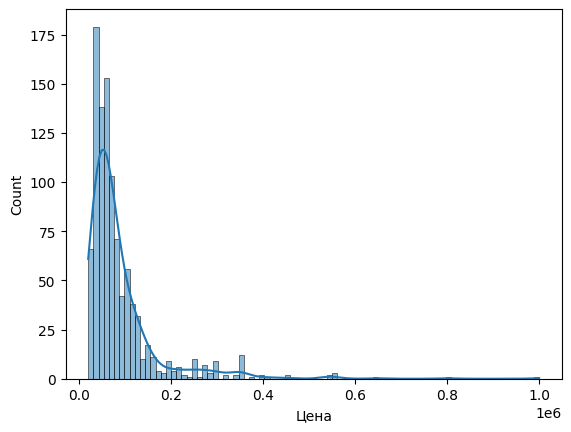

In [226]:
import seaborn as sns
sns.histplot(df_info['Цена'], kde=True)
#тут стоит ось x не в теор значених указать 

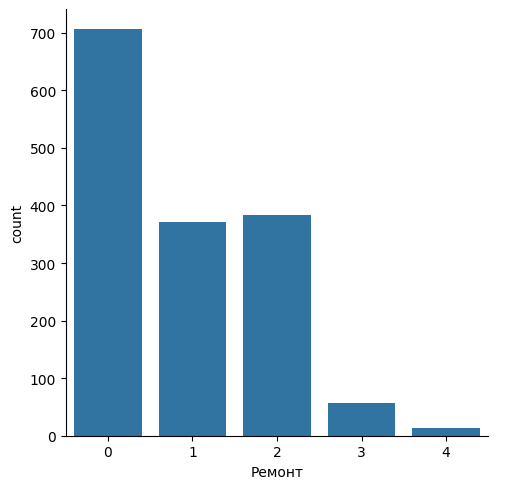

In [230]:
#Оценим категориальные переменные перед их заменой на числовые значения
sns.catplot(x = df_info['Ремонт'], data = df_info, kind = 'count')

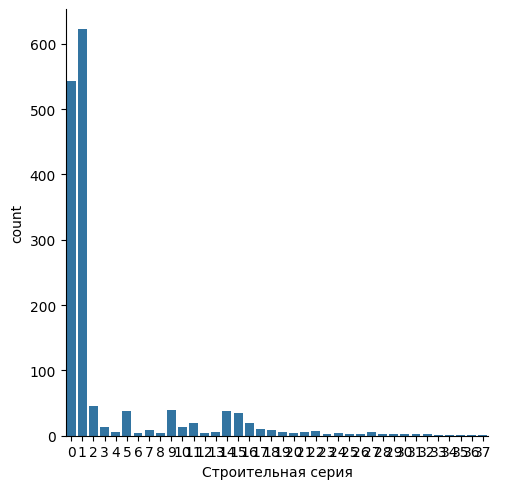

In [228]:
sns.catplot(x = df_info['Строительная серия'], data = df_info, kind = 'count' )
#тут надо бы чуть растянуть ось x, чтобы числа вмещались

In [ ]:
#тут хочу график, где каждвй столбец задает среднюю цену недвижимости по каждой строительной серии

In [ ]:
#что неверно здесь?
sns.heatmap(df_info[df_info.columns.values[:-3]+df_info.columns.values[-1]].corr(method='pearson', annot=True,cmap='viridis', fmt='.1f'))

In [188]:
#теперь необходимо привести категориальные переменные в должный вид. Необходимо определить все возможные варианты по каждой категориальной переменной. Далее нужно использовать "One hot encoding". Это необходимо, так как не всегда можно эффективно работать с категориальными переменными при машинной обучении
print(df_info['Ремонт'].unique())
print(df_info['Строительная серия'].unique())
print(df_info['Тип дома'].unique())
print(df_info['Аварийность'].unique())

['Евроремонт' 'Дизайнерский' 'Косметический' nan 'Без ремонта']
['Индивидуальный проект' nan 'II-18' '1-510' 'П-47' '1-515' 'II-29'
 'И-155' 'П-44К' 'П-44' 'П-3' 'П-46' 'П-55' '1-511' 'II-49' 'П-44Т'
 'ii-68' '1605-АМ' 'П-43' 'И-209А' 'П-111М' 'II-57' 'П-30' 'И-700' 'КОПЭ'
 'П-44М' 'II-18-01/12' 'П-3М' 'П-46М' '1МГ-601' 'II-05' 'Башня Вулыха'
 'И-209' 'И-522А' 'П-22' 'II-32' 'И-700А' '1-300']
['Монолитный' nan 'Панельный' 'Блочный' 'Кирпичный' 'Монолитно-кирпичный'
 'Сталинский']
['Нет' nan]


In [ ]:
#Заметим, что столбец "Аварийность" по сути бессмыслен, так как в нашей выборке нет ни одного дома в аварийном состоянии, но это и логично. Следовательно, стоит просто удалить этот столбец
df_info.drop('Аварийность', axis = 1, inplace = True)



In [193]:
#Создадим словари, где укажем новое обзначение категориальных переменных
#Ремонт:
renocation = {}
for numb in range(len(df_info['Ремонт'].unique())):
    renocation[df_info['Ремонт'].unique()[numb]] = numb
print(renocation)
#Строительная серия:
series = {}
for numb in range(len(df_info['Строительная серия'].unique())):
    series[df_info['Строительная серия'].unique()[numb]] = numb
print(series)

#Тип дома:
house_types = {}
for numb in range(len(df_info['Тип дома'].unique())):
    house_types[df_info['Тип дома'].unique()[numb]] = numb
print(house_types)

{'Евроремонт': 0, 'Дизайнерский': 1, 'Косметический': 2, nan: 3, 'Без ремонта': 4}
{'Индивидуальный проект': 0, nan: 1, 'II-18': 2, '1-510': 3, 'П-47': 4, '1-515': 5, 'II-29': 6, 'И-155': 7, 'П-44К': 8, 'П-44': 9, 'П-3': 10, 'П-46': 11, 'П-55': 12, '1-511': 13, 'II-49': 14, 'П-44Т': 15, 'ii-68': 16, '1605-АМ': 17, 'П-43': 18, 'И-209А': 19, 'П-111М': 20, 'II-57': 21, 'П-30': 22, 'И-700': 23, 'КОПЭ': 24, 'П-44М': 25, 'II-18-01/12': 26, 'П-3М': 27, 'П-46М': 28, '1МГ-601': 29, 'II-05': 30, 'Башня Вулыха': 31, 'И-209': 32, 'И-522А': 33, 'П-22': 34, 'II-32': 35, 'И-700А': 36, '1-300': 37}
{'Монолитный': 0, nan: 1, 'Панельный': 2, 'Блочный': 3, 'Кирпичный': 4, 'Монолитно-кирпичный': 5, 'Сталинский': 6}


In [195]:
#Напишем функциЯ замены категориальных переменных на числовые значения
def categor(value,dic):
    value = dic[value]
    return(value)



In [ ]:
df_info['Ремонт'] = df_info['Ремонт'].map(lambda value: categor(value,renocation))
df_info['Строительная серия'] = df_info['Строительная серия'].map(lambda value: categor(value,series))
df_info['Тип дома'] = df_info['Тип дома'].map(lambda value: categor(value,house_types))

In [199]:
df_info['Строительная серия'] = df_info['Строительная серия'].map(lambda value: categor(value,series))
df_info['Тип дома'] = df_info['Тип дома'].map(lambda value: categor(value,house_types))

In [200]:
df_info.head()

,Цена,Пешком до метро,Общая площадь,Жилая площадь,Площадь кухни,Высота потолков,Санузел,Балкон/лоджия,Ремонт,Год постройки,Строительная серия,Тип дома,В квартире есть,В квартире есть - кол-во
Link,,,,,,,,,,,,,,
https://www.cian.ru/rent/flat/301061437/,110000,1.0,11,12.0,3.0,10.0,1.0,1.0,0,10.0,0,0,"[Холодильник, Посудомоечная машина, Стиральная...",9.0
https://www.cian.ru/rent/flat/301067187/,110000,1.0,12,5.0,2.0,10.0,1.0,1.0,1,10.0,0,0,"[Холодильник, Стиральная машина, Интернет, Ван...",5.0
https://www.cian.ru/rent/flat/301599048/,33000,7.0,8,NaN,NaN,3.0,1.0,1.0,1,5.0,1,1,"[Холодильник, Стиральная машина, Интернет, Ван...",6.0
https://www.cian.ru/rent/flat/278216280/,ID,1.0,9,NaN,NaN,NaN,1.0,NaN,1,8.0,1,0,"[Холодильник, Посудомоечная машина, Стиральная...",10.0
https://www.cian.ru/rent/flat/301787649/,105990,6.0,9,7.0,6.0,3.0,NaN,1.0,0,9.0,1,0,"[Холодильник, Стиральная машина, Кондиционер, ...",8.0
